In [1262]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from datetime import datetime, time
from prophet import Prophet
import glob
import matplotlib.pyplot as plt

from autogluon.tabular import TabularDataset, TabularPredictor

In [1263]:
# obtain and sort required raw data
degree_days = 'gw_hdd'
path = "RawData"

def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    date = parts[1]
    time = parts[2]
    return date, time

def get_date(df, file):
    """get the date from the dataframe and the time from the filename and combine them into a datetime object
    :param df: dataframe containing the date
    :param file: filename containing the time
    :return: datetime object
    """
    # date_str = df[df.iloc[:, 2] == 1].iloc[0]['Date']
    date_str = str(file.split('.')[1])
    time_str = str(file.split('.')[2])
    # date = datetime.strptime(date_str, '%Y-%m-%d')
    date = datetime.strptime(date_str, '%Y%m%d')
    time_value = time(int(time_str), 0)
    combined_datetime = datetime.combine(date.date(), time_value)
    return combined_datetime

degree_days = degree_days
ecmwf_files = glob.glob(path + f'/ecmwf.*.[01][02].{degree_days}.csv')
ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

ecmwf_ens_files = glob.glob(path + f'/ecmwf-eps.*.[01][02].{degree_days}.csv')
ecmwf_ens_sorted_files = sorted(ecmwf_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

gfs_ens_bc_files = glob.glob(path + f'/gfs-ens-bc.*.[01][02].{degree_days}.csv')
gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

cmc_ens_files = glob.glob(path + f'/cmc-ens.*.[01][02].{degree_days}.csv')
cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]
for _ in range(2):
    set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
    set2 = set((extract_date_time(filename) for filename in ecmwf_ens_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
    ecmwf_ens_sorted_files = [filename for filename in ecmwf_ens_sorted_files if
                              extract_date_time(filename) in set1]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

    master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]

    master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
    ecmwf_ens_sorted_files = [filename for filename in ecmwf_ens_sorted_files if
                              extract_date_time(filename) in master_set]
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if
                            extract_date_time(filename) in master_set]

### process raw data into individual components for model

In [1264]:
# y
# euro ensemble - values to predict
ecmwf_ens_9_14 = pd.DataFrame(columns=['ens(9,14)'])

for i in range(1, len(ecmwf_ens_sorted_files)):
    ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
    ecmwf_ens_df = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(ecmwf_ens_df, ecmwf_ens_sorted_files[i])
    prev_date = get_date(prev_ecmwf_ens_df, ecmwf_ens_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = ecmwf_ens_df['Value'].iloc[8:14].sum()
    prev = prev_ecmwf_ens_df['Value'].iloc[(8+offset):(14+offset)].sum()
    change = cur - prev

    new_row = pd.DataFrame(change, columns=ecmwf_ens_9_14.columns, index=[date])
    ecmwf_ens_9_14 = pd.concat([ecmwf_ens_9_14, new_row])

In [1265]:
# X1
# euro ensemble day 8
ecmwf_ens_8 = pd.DataFrame(columns=['ens(8)'])

for i in range(1, len(ecmwf_ens_sorted_files)):
    ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
    ecmwf_ens_df = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(ecmwf_ens_df, ecmwf_ens_sorted_files[i])
    prev_date = get_date(prev_ecmwf_ens_df, ecmwf_ens_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = ecmwf_ens_df['Value'].iloc[7:8].sum()
    prev = prev_ecmwf_ens_df['Value'].iloc[(7+offset):(8+offset)].sum()
    change = cur - prev

    new_row = pd.DataFrame(change, columns=ecmwf_ens_8.columns, index=[date])
    ecmwf_ens_8 = pd.concat([ecmwf_ens_8, new_row])

In [1266]:
# X2
# ecmwf(9,10) - ecmwf_ens-1(9,10)

ecmwf_9_10 = pd.DataFrame(columns=['ecmwf(9,10)'])

for i in range(1, len(ecmwf_sorted_files)):
    ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
    ecmwf_df = ecmwf_df[ecmwf_df[ecmwf_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i-1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(ecmwf_df, ecmwf_sorted_files[i])
    prev_date = get_date(prev_ecmwf_ens_df, ecmwf_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = ecmwf_df['Value'].iloc[8:10].sum()
    prev = prev_ecmwf_ens_df['Value'].iloc[(8+offset):(10+offset)].sum()
    change = cur - prev

    new_row = pd.DataFrame(change, columns=ecmwf_9_10.columns, index=[date])
    ecmwf_9_10 = pd.concat([ecmwf_9_10, new_row])

In [1267]:
# X3
# gfs(11,14) - ecmwf_ens-1(11,14)

gfs_11_14 = pd.DataFrame(columns=['gfs(11,14)'])

for i in range(1, len(gfs_ens_bc_sorted_files)):
    gfs_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_df = gfs_df[gfs_df[gfs_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i-1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(gfs_df, gfs_ens_bc_sorted_files[i])
    prev_date = get_date(prev_ecmwf_ens_df, ecmwf_ens_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = gfs_df['Value'].iloc[10:14].sum()
    prev = prev_ecmwf_ens_df['Value'].iloc[(10+offset):(14+offset)].sum()
    change = cur - prev

    new_row = pd.DataFrame(change, columns=gfs_11_14.columns, index=[date])
    gfs_11_14 = pd.concat([gfs_11_14, new_row])

In [1268]:
# X4
# cmc(9,14) - gfs(9,14)

cmc_9_14 = pd.DataFrame(columns=['cmc(9,14)'])

for i in range(1, len(cmc_ens_sorted_files)):
    cmc_df = pd.read_csv(cmc_ens_sorted_files[i])
    cmc_df = cmc_df[cmc_df[cmc_df.columns[2]] >= 1]
    gfs_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_df = gfs_df[gfs_df[gfs_df.columns[2]] >= 1]

    date = get_date(cmc_df, cmc_ens_sorted_files[i])

    cmc = cmc_df['Value'].iloc[8:14].sum()
    gfs = gfs_df['Value'].iloc[8:14].sum()
    change = cmc - gfs

    new_row = pd.DataFrame(change, columns=cmc_9_14.columns, index=[date])
    cmc_9_14 = pd.concat([cmc_9_14, new_row])

# testing

In [1269]:
i = 2

d1 = ecmwf_ens_sorted_files[i].split('.')[1]
d2 = ecmwf_ens_sorted_files[i - 1].split('.')[1]

ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
v1 = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
v2 = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

In [1270]:
print(ecmwf_ens_sorted_files[i])
print(ecmwf_ens_sorted_files[i - 1])

RawData/ecmwf-eps.20180711.12.gw_hdd.csv
RawData/ecmwf-eps.20180711.00.gw_hdd.csv


In [1271]:
if d1 == d2:
    offset = 1
else:
    offset = 0

In [1272]:
a = v1.iloc[7:8]

In [1273]:
b = v2.iloc[7+offset:8+offset]

In [1274]:
a['Value'].sum() - b['Value'].sum()

0.002999999999999999

In [1275]:
display(a)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
15,2018-07-19,0.009,1


In [1276]:
display(b)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
15,2018-07-19,0.006,1


In [1277]:
display(v1)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
8,2018-07-12,0.003,1
9,2018-07-13,0.005,1
10,2018-07-14,0.003,1
11,2018-07-15,0.001,1
12,2018-07-16,0.003,1
13,2018-07-17,0.001,1
14,2018-07-18,0.004,1
15,2018-07-19,0.009,1
16,2018-07-20,0.007,1
17,2018-07-21,0.004,1


In [1278]:
display(v2)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
7,2018-07-11,0.007,1
8,2018-07-12,0.002,1
9,2018-07-13,0.005,1
10,2018-07-14,0.004,1
11,2018-07-15,0.002,1
12,2018-07-16,0.004,1
13,2018-07-17,0.002,1
14,2018-07-18,0.004,1
15,2018-07-19,0.006,1
16,2018-07-20,0.004,1


In [1279]:
display(ecmwf_ens_8.head())

,ens(8)
2018-07-11 00:00:00,0.002
2018-07-11 12:00:00,0.003
2018-07-12 00:00:00,-0.002
2018-07-12 12:00:00,-0.002
2018-07-13 00:00:00,-0.001


# model

In [1350]:
master_df = pd.concat([ecmwf_ens_9_14, ecmwf_ens_8, ecmwf_9_10, gfs_11_14, cmc_9_14], axis=1)

In [1351]:
data = master_df.copy()

In [1352]:
#get only noon forecast
data['hour'] = data.index.hour
data = data[data['hour'] == 12]
data.drop('hour', axis=1, inplace=True)

In [1353]:
display(data.columns)

Index(['ens(9,14)', 'ens(8)', 'ecmwf(9,10)', 'gfs(11,14)', 'cmc(9,14)'], dtype='object')

In [1354]:
if 'hdd' in degree_days:
    print('getting betas for hdd')
    b1 = 0.76947604258751
    b2 = 0.6555933110283885
    b3 = 0.16964083221789059
    b4 = 0.06680336217511197

else:
    print('getting betas for cdd')
    b1 = 1.7687808214521186
    b2 =0.42218026473687276
    b3 = 0.1128916050374201
    b4 = 0.08538981339364801

getting betas for hdd


In [1355]:
(b1*0.003) + (b2*0.088) + (b3*0.037) + (b4*-0.040)

0.06360521580331818

In [1356]:
features = ['ens(8)', 'ecmwf(9,10)', 'gfs(11,14)', 'cmc(9,14)']
X = data[features]

In [1357]:
X

,ens(8),"ecmwf(9,10)","gfs(11,14)","cmc(9,14)"
2018-07-11 12:00:00,0.003,0.088,0.037,-0.040
2018-07-12 12:00:00,-0.002,0.045,0.036,-0.053
2018-07-13 12:00:00,0.000,0.021,0.028,-0.048
2018-07-14 12:00:00,-0.001,-0.007,0.036,-0.053
2018-07-15 12:00:00,0.000,0.002,0.024,-0.039
...,...,...,...,...
2023-05-12 12:00:00,-1.098,-0.773,0.803,-2.337
2023-05-13 12:00:00,-0.563,0.351,1.843,0.595
2023-05-14 12:00:00,0.210,0.871,1.201,-2.417
2023-05-15 12:00:00,-0.080,2.357,1.071,-2.618


In [1358]:
label = 'ens(9,14)'
y = data[label]

In [1359]:
y

2018-07-11 12:00:00    0.004
2018-07-12 12:00:00    0.001
2018-07-13 12:00:00    0.001
2018-07-14 12:00:00    0.000
2018-07-15 12:00:00    0.012
                       ...  
2023-05-12 12:00:00    0.378
2023-05-13 12:00:00   -0.801
2023-05-14 12:00:00    0.524
2023-05-15 12:00:00    1.045
2023-05-16 12:00:00   -0.083
Name: ens(9,14), Length: 1749, dtype: float64

In [1360]:
regression_preds = (b1 * X.iloc[:,0]) + (b2 * X.iloc[:,1]) + (b3 * X.iloc[:,2]) + (b4 * X.iloc[:,3])

In [1361]:
y[-225:]

2022-10-04 12:00:00    3.505
2022-10-05 12:00:00    3.098
2022-10-06 12:00:00    7.153
2022-10-07 12:00:00   -8.197
2022-10-08 12:00:00    5.206
                       ...  
2023-05-12 12:00:00    0.378
2023-05-13 12:00:00   -0.801
2023-05-14 12:00:00    0.524
2023-05-15 12:00:00    1.045
2023-05-16 12:00:00   -0.083
Name: ens(9,14), Length: 225, dtype: float64

In [1362]:
mse = mean_squared_error(y[-225:], regression_preds[-225:])
mse

28.923662742350903

In [1363]:
forecasting_errors = y - regression_preds

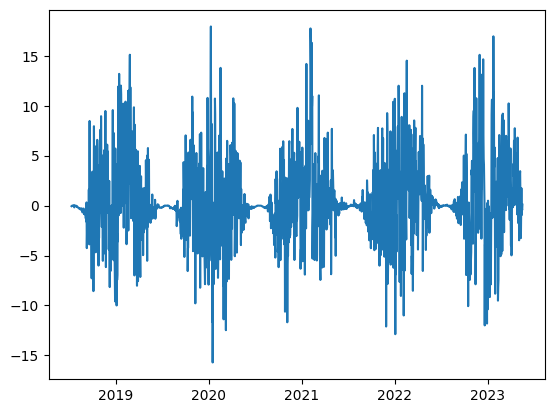

In [1364]:
plt.plot(forecasting_errors)

### forecasting errors linear regression

In [1380]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

In [1371]:
X_train, X_test, y_train, y_test = train_test_split(X, forecasting_errors, test_size=0.15, shuffle=False)

In [1373]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.33258700056331014

In [1374]:
reg.coef_

array([ 0.45491005, -0.40453131,  0.01530261, -0.01174598])

In [1375]:
error_preds = reg.predict(X_test)
(((error_preds[-225:] + regression_preds[-225:]) - y[-225:]) ** 2).mean()

18.488725082342487

In [1377]:
import statsmodels.api as sm
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.105
Model:                            OLS   Adj. R-squared (uncentered):              0.103
Method:                 Least Squares   F-statistic:                              43.61
Date:                Wed, 21 Jun 2023   Prob (F-statistic):                    1.23e-34
Time:                        12:34:05   Log-Likelihood:                         -4016.6
No. Observations:                1486   AIC:                                      8041.
Df Residuals:                    1482   BIC:                                      8062.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


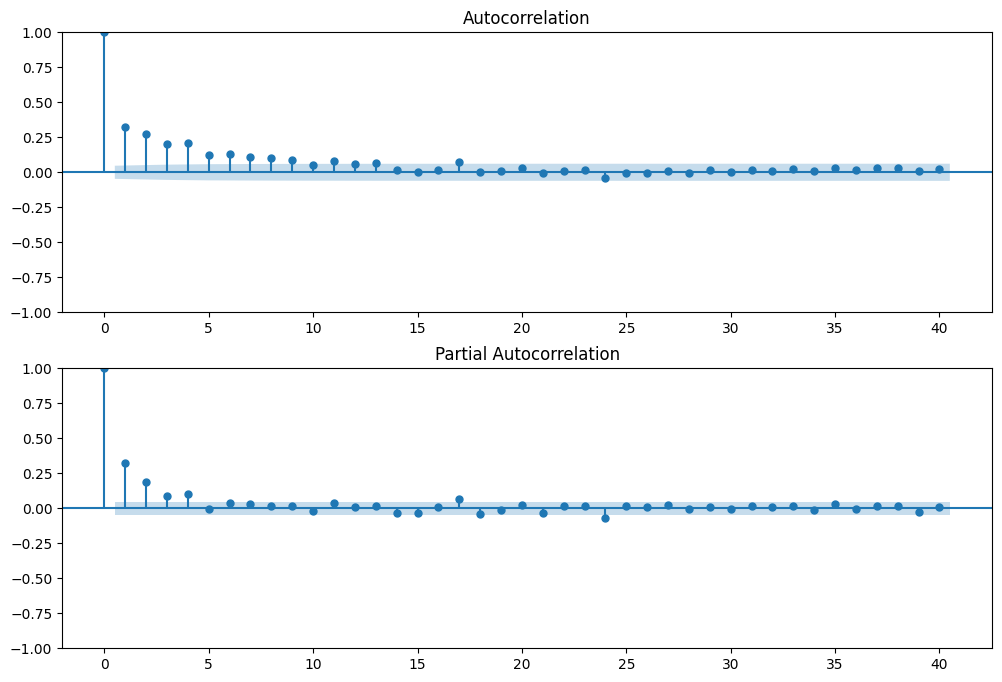

In [1379]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(forecasting_errors.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(forecasting_errors, lags=40, ax=ax2)

In [1401]:
mod = sm.tsa.statespace.SARIMAX(forecasting_errors, trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1749
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4798.172
Date:                Wed, 21 Jun 2023   AIC                           9604.344
Time:                        12:50:42   BIC                           9626.209
Sample:                             0   HQIC                          9612.427
                               - 1749                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.009      0.015      0.988      -0.018       0.019
ar.L1          0.1797      0.021      8.743      0.000       0.139       0.220
ma.L1         -0.8966      0.009    -95.778      0.0

In [1415]:
start_date = '2022-10-04'
end_date = '2023-05-16'
predict = res.predict(start=start_date, end=end_date)

In [1416]:
predict

2022-10-04 12:00:00   -0.763451
2022-10-05 12:00:00    0.482211
2022-10-06 12:00:00    1.194636
2022-10-07 12:00:00    2.277807
2022-10-08 12:00:00   -1.200669
                         ...   
2023-05-12 12:00:00    0.217086
2023-05-13 12:00:00    0.835242
2023-05-14 12:00:00    0.165659
2023-05-15 12:00:00    0.248413
2023-05-16 12:00:00    0.141855
Name: predicted_mean, Length: 225, dtype: float64

In [1417]:
(((predict + regression_preds[-225:]) - y[-225:])** 2).mean()

21.945447215733633

### forecasting errors - prophet

In [1300]:
errors = forecasting_errors.to_frame()
errors['ds'] = errors.index
errors.rename(columns={0:'y'}, inplace=True)
errors.reset_index(drop=True, inplace=True)

In [1301]:
train_len = 0.85
train_errors = errors.iloc[:int(len(errors)*train_len)]
test_errors = errors.iloc[int(len(errors)*train_len):]

In [1302]:
m = Prophet()
m.fit(train_errors)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/cxaimmwx.json
DEBUG:cmdstanpy:input tempfile: /var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/subkq4gs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76612', 'data', 'file=/var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/cxaimmwx.json', 'init=/var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/subkq4gs.json', 'output', 'file=/var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/prophet_model62odpyqh/prophet_model-20230621120629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

In [1303]:
future = m.make_future_dataframe(periods=263)
future.tail()

,ds
1744,2023-05-12 12:00:00
1745,2023-05-13 12:00:00
1746,2023-05-14 12:00:00
1747,2023-05-15 12:00:00
1748,2023-05-16 12:00:00


In [1304]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1744,2023-05-12 12:00:00,-0.405323,-4.982916,4.440868
1745,2023-05-13 12:00:00,-0.446582,-5.530465,4.203398
1746,2023-05-14 12:00:00,-0.133364,-5.038364,4.602251
1747,2023-05-15 12:00:00,0.438097,-4.535929,5.477081
1748,2023-05-16 12:00:00,0.001857,-4.270749,4.316580


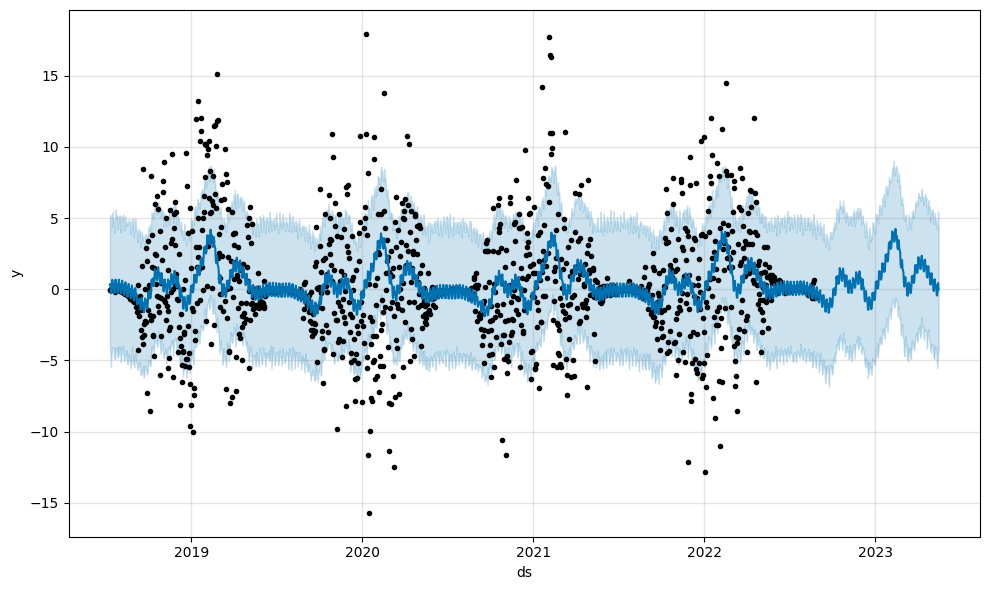

In [1305]:
fig1 = m.plot(forecast)

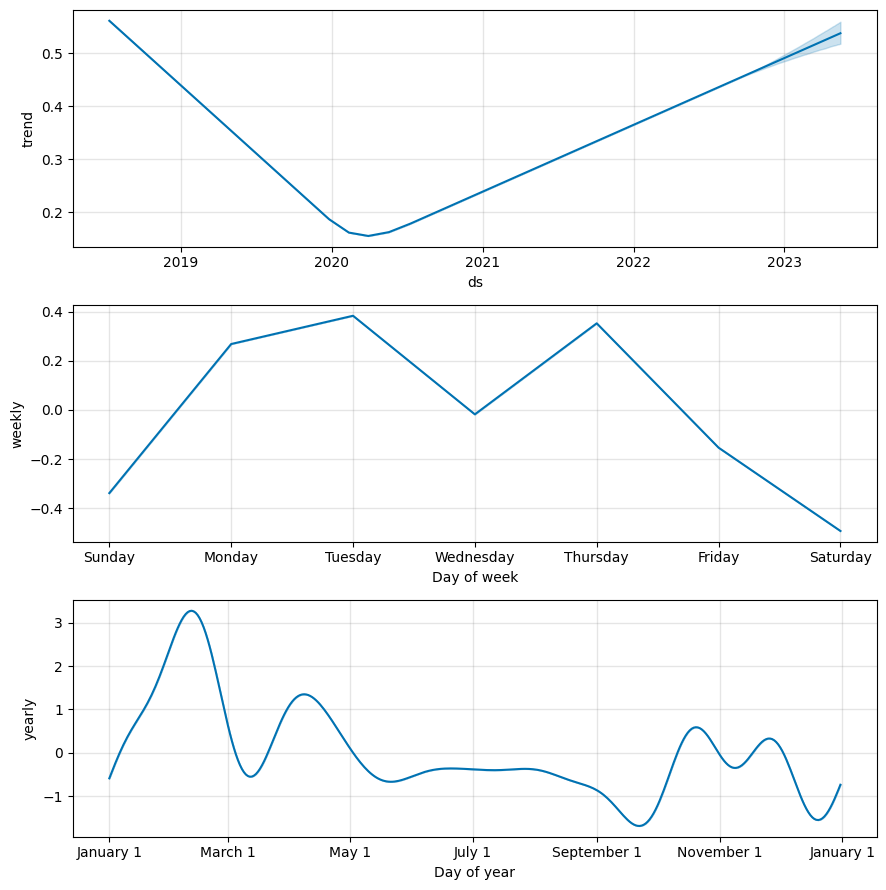

In [1306]:
fig2 = m.plot_components(forecast)

In [1307]:
forecasted_errors = forecast[['ds', 'yhat']]
forecasted_errors.set_index('ds', inplace=True)

In [1308]:
# errors without adjustment
((regression_preds[-225:] - y[-225:]) **2).mean()

28.923662742350903

In [1309]:
(((regression_preds[-225:] + forecasted_errors['yhat'][-225:]) - y[-225:])**2).mean()

29.352188423546476

### forecasting errors - autogluon

In [1310]:
data_df = data.copy()

In [1311]:
data_df['errors'] = forecasting_errors

In [1312]:
data_df.drop('ens(9,14)', axis=1, inplace=True)

In [1313]:
label = 'errors'
features = ['ens(8)', 'ecmwf(9,10)', 'gfs(11,14)', 'cmc(9,14)']

In [1314]:
train_len = 0.85

In [1315]:
train_data = TabularDataset(data_df.iloc[:int(len(data_df)*train_len)])
test_data = TabularDataset(data_df.iloc[int(len(data_df)*train_len):])

In [1316]:
train_data

,ens(8),"ecmwf(9,10)","gfs(11,14)","cmc(9,14)",errors
2018-07-11 12:00:00,0.003,0.088,0.037,-0.040,-0.059605
2018-07-12 12:00:00,-0.002,0.045,0.036,-0.053,-0.029529
2018-07-13 12:00:00,0.000,0.021,0.028,-0.048,-0.014311
2018-07-14 12:00:00,-0.001,-0.007,0.036,-0.053,0.002792
2018-07-15 12:00:00,0.000,0.002,0.024,-0.039,0.009223
...,...,...,...,...,...
2022-08-22 12:00:00,0.031,-0.265,2.083,-3.034,-0.586802
2022-08-23 12:00:00,0.016,0.539,1.062,-1.052,0.640442
2022-08-24 12:00:00,0.166,0.209,0.659,-0.764,-0.273508
2022-08-25 12:00:00,0.139,0.043,0.221,-1.111,-0.568420


In [1317]:
test_data

,ens(8),"ecmwf(9,10)","gfs(11,14)","cmc(9,14)",errors
2022-08-27 12:00:00,-0.098,0.280,0.934,-0.500,-0.428200
2022-08-28 12:00:00,0.182,0.359,1.993,-0.988,0.291505
2022-08-29 12:00:00,0.067,0.494,1.077,-1.045,-1.001312
2022-08-30 12:00:00,-0.092,0.420,1.461,0.594,-0.299084
2022-08-31 12:00:00,-0.033,0.435,1.372,-1.661,-0.562577
...,...,...,...,...,...
2023-05-12 12:00:00,-1.098,-0.773,0.803,-2.337,1.749556
2023-05-13 12:00:00,-0.563,0.351,1.843,0.595,-0.950294
2023-05-14 12:00:00,0.210,0.871,1.201,-2.417,-0.250887
2023-05-15 12:00:00,-0.080,2.357,1.071,-2.618,-0.445469


In [1318]:
predictor = TabularPredictor(label=label).fit(train_data, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230621_180630/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230621_180630/"
AutoGluon Version:  0.7.0
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:53:44 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T8103
Train Data Rows:    1486
Train Data Columns: 4
Label Column: errors
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (17.931256573045424, -15.70444824739661, 0.30115, 3.80706)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may spe

In [1319]:
test_data_no_lab = test_data.drop(columns=[label])
test_data_no_lab

,ens(8),"ecmwf(9,10)","gfs(11,14)","cmc(9,14)"
2022-08-27 12:00:00,-0.098,0.280,0.934,-0.500
2022-08-28 12:00:00,0.182,0.359,1.993,-0.988
2022-08-29 12:00:00,0.067,0.494,1.077,-1.045
2022-08-30 12:00:00,-0.092,0.420,1.461,0.594
2022-08-31 12:00:00,-0.033,0.435,1.372,-1.661
...,...,...,...,...
2023-05-12 12:00:00,-1.098,-0.773,0.803,-2.337
2023-05-13 12:00:00,-0.563,0.351,1.843,0.595
2023-05-14 12:00:00,0.210,0.871,1.201,-2.417
2023-05-15 12:00:00,-0.080,2.357,1.071,-2.618


In [1320]:
error_pred = predictor.predict(test_data_no_lab)
error_pred.head()

2022-08-27 12:00:00   -0.110713
2022-08-28 12:00:00    0.023934
2022-08-29 12:00:00   -0.132999
2022-08-30 12:00:00   -0.130139
2022-08-31 12:00:00   -0.177569
Name: errors, dtype: float32

In [1321]:
predictor.evaluate(test_data, silent=True)

/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -4.209400958816135,
 'mean_squared_error': -17.719056432082198,
 'mean_absolute_error': -3.151489277655903,
 'r2': 0.26887433006313766,
 'pearsonr': 0.5737739421287498,
 'median_absolute_error': -2.429913601386839}

In [1322]:
(((error_pred[-225:] + regression_preds[-225:]) - y)**2).dropna().mean()

20.310227972683183

In [1323]:
((error_pred[-225:] - test_data[label][-225:]) ** 2).dropna().mean()

20.310227972683183

In [1324]:
error_pred[-225:]

2022-10-04 12:00:00    0.804203
2022-10-05 12:00:00    1.719710
2022-10-06 12:00:00    0.512373
2022-10-07 12:00:00    1.153073
2022-10-08 12:00:00    0.999618
                         ...   
2023-05-12 12:00:00    0.311009
2023-05-13 12:00:00   -0.173907
2023-05-14 12:00:00   -0.207361
2023-05-15 12:00:00   -1.126929
2023-05-16 12:00:00   -0.074239
Name: errors, Length: 225, dtype: float32

In [1325]:
import xgboost as xgb

In [1326]:
label_df = train_data[label]
train_data = train_data[features]

In [1327]:
dtrain = xgb.DMatrix(train_data, label=label_df)

In [1328]:
bst = xgb.train(params={'objective': 'reg:squarederror'}, dtrain=dtrain)

In [1329]:
test_data = test_data[features]

In [1330]:
dtest = xgb.DMatrix(test_data)
ypred = bst.predict(dtest)

In [1332]:
(((ypred[-225:] + regression_preds[-225:]) - y[-225:]) ** 2).mean()

25.418674005823817

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

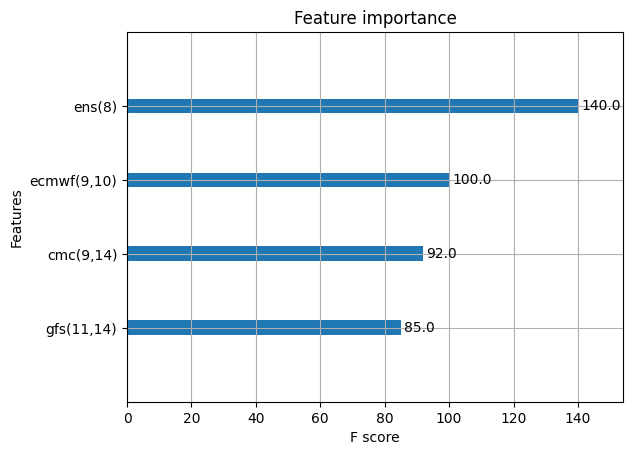

In [1333]:
xgb.plot_importance(bst)

### improving model through deep learning

In [1334]:
deep_preds = pd.read_pickle("predictions.pkl")

In [1335]:
deep_preds = deep_preds.to_frame()

In [1336]:
deep_preds.rename(columns={0:'prediction'}, inplace=True)

In [1337]:
y = y.to_frame()

In [1338]:
#combine deep_pred and y
deep_preds['y'] = y['ens(9,14)']

In [1339]:
deep_preds.dropna(inplace=True)

In [1340]:
((deep_preds[deep_preds.columns[0]][-225:] - deep_preds[deep_preds.columns[1]][-225:])**2).mean()

16.420015403740226

In [1344]:
display(deep_preds[-225:])

,prediction,y
2022-10-04 12:00:00,1.263886,3.505
2022-10-05 12:00:00,-0.083238,3.098
2022-10-06 12:00:00,-0.318173,7.153
2022-10-07 12:00:00,2.818476,-8.197
2022-10-08 12:00:00,2.757661,5.206
...,...,...
2023-05-12 12:00:00,-1.005183,0.378
2023-05-13 12:00:00,0.757259,-0.801
2023-05-14 12:00:00,0.212637,0.524
2023-05-15 12:00:00,0.439371,1.045
